In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.datasets import make_blobs

In [2]:
class_1 = 500 #类别1有500个样本
class_2 = 50 #类别2只有50个
centers = [[0.0, 0.0], [2.0, 2.0]] #设定两个类别的中心
clusters_std = [1.5, 0.5] #设定两个类别的方差，通常来说，样本量比较大的类别会更加松散
X, y = make_blobs(n_samples=[class_1, class_2],
                  centers=centers,
                  cluster_std=clusters_std,
                  random_state=0,
                  shuffle=False)
#不设定class_weight
clf = svm.SVC(kernel='linear', C=1.0)
clf.fit(X, y)
#设定class_weight
wclf = svm.SVC(kernel='linear', class_weight={1: 10})
wclf.fit(X, y)

SVC(class_weight={1: 10}, kernel='linear')

**捕获少数类的能力**和**将多数类判错后需要付出的成本**的平衡。

# 一、混淆矩阵（Confusion Matrix）

-|-|预测值|预测值|合计
:-:|:-:|:-:|:-:|:-:
-|-|1|0|-
真实值|1|11|10|真实为1：11+10
真实值|0|01|00|真实为0：01+00
-|-|判断为1：11+01|判断为0：10+00|全部样本之和：11+10+01+00

少数类是1，多数类是0。混淆矩阵中，永远是真实值在前，预测值在后。容易看出，11和00的对角线就是全部预测正确的，01和10的对角线就是全部预测错误的。基于混淆矩阵，有6个不同的模型评估指标，这些评估指标的范围都在[0,1]之间，所有以11和00为分子的指标都是越接近1越好，所有以01和10为分子的指标都是越接近0越好。

## （一）模型整体效果：准确率

$$Accuracy=\frac{11+00}{11+10+01+00}$$

准确率Accuracy是所有预测正确的所有样本除以总样本，通常来说越接近1越好。

## （二）捕捉少数类的艺术：精确度、召回率、F1 score和假负率

### 1.精确度

精确度Precision，又叫查准率，表示所有被预测为少数类的样本中，真正的少数类所占的比例。在支持向量机中，精确度可以被表示为决策边界上方的所有点中，红色点所占的比例。精确度越高，代表我们捕捉正确的红色点越多，对少数类的预测越精确。精确度越低，则代表误伤了过多的多数类。精确度是**将多数类判错后付出的成本**的衡量。

$$Accuracy=\frac{11}{11+01}$$

In [3]:
#对于没有class_weight，没有做样本平衡的灰色决策边界来说：
(y[y == clf.predict(X)] == 1).sum()/(clf.predict(X) == 1).sum()

0.7142857142857143

In [4]:
#对于有class_weight，做了样本平衡的红色决策边界来说：
(y[y == wclf.predict(X)] == 1).sum()/(wclf.predict(X) == 1).sum()

0.5102040816326531

可以看出，做了样本平衡之后，精确度是下降的。因为样本平衡之后，有更多的多数类（紫色点）被误伤了。精确度可以帮助我们判断，是否每一次对少数类的预测都精确，所以又被称为“查准率”。在现实的样本不平衡例子中，当每一次将多数类判断错误的成本非常高昂的时候（比如大众召回车辆的例子），则追求高精确度。精确度越低，对多数类的判断就会越错误。如果目标是不计一切代价捕获少数类，那我们并不在意精确度。

### 2.召回率

召回率Recall，又被称为敏感度(sensitivity)、真正率、查全率，表示所有真实为1的样本中，被预测正确的样本所占的比例。在支持向量机中，召回率可以被表示为决策边界上方的所有红色点占全部样本中的红色点的比例。召回率越高，代表捕捉出了越多的少数类，召回率越低，代表没有捕捉出足够的少数类。

$$Recall=\frac{11}{11+10}$$

In [5]:
#对于没有class_weight，没有做样本平衡的灰色决策边界来说：
(y[y == clf.predict(X)] == 1).sum()/(y == 1).sum()

0.6

In [6]:
#对于有class_weight，做了样本平衡的红色决策边界来说：
(y[y == wclf.predict(X)] == 1).sum()/(y == 1).sum()

1.0

可以看出，做样本平衡之前，只成功捕获了60%左右的少数类点，而做了样本平衡之后的模型，捕捉出了100%的少数类点。

如果希望不计一切代价找出少数类（比如找出潜在犯罪者的例子），那就追求高召回率。召回率和精确度是此消彼长的，两者之间的平衡代表了**捕捉少数类的需求**和**尽量不要误伤多数类的需求**的平衡。偏向于哪一方，取决于业务需求：是误伤多数类的成本更高，还是无法捕捉少数类的代价更高。

### 3.F1 measure

为了同时兼顾精确度和召回率，创造了两者的**调和平均数**作为考量两者平衡的综合性指标，称为F1 measure。追求尽量高的F1 measure，能够保证精确度和召回率都比较高。F1 measure在[0,1]之间分布，越接近1越好。

$$F-measure=\frac{2}{\frac{1}{Precision}+\frac{1}{Recall}}=\frac{2*Precision*Recall}{Precision+Recall}$$

### 4.假负率（False Negative Rate）

从Recall延申出来的另一个评估指标叫做假负率（False Negative Rate），等于1-Recall，用于衡量所有真实为1的样本中，被错误判断为0的样本比例，越接近0越好。

$$FNR=\frac{10}{11+10}$$

## （三）判错多数类的考量：特异度和假正率

### 1.特异度（Specificity）

特异度(Specificity)表示所有真实为0的样本中，被正确预测为0的样本所占的比例，衡量了模型将多数类判断正确的能力，越接近1越好。在支持向量机中，可以表示为决策边界下方的点占所有紫色点的比例。

$$Specificity=\frac{00}{01+00}$$

In [7]:
#对于没有class_weight，没有做样本平衡的灰色决策边界来说：
(y[y == clf.predict(X)] == 0).sum()/(y == 0).sum()

0.976

In [8]:
#对于有class_weight，做了样本平衡的红色决策边界来说：
(y[y == wclf.predict(X)] == 0).sum()/(y == 0).sum()

0.904

### 2.假正率（False Positive Rate）

假正率（False Positive Rate）等于1-specificity，是模型将多数类判断错误的能力，越接近0越好。在支持向量机中，假正率就是决策边界上方的紫色点（所有被判断错误的多数类）占所有紫色点的比例。

## （四）sklearn中的混淆矩阵

类|含义
:-|:-
sklearn.metrics.confusion_matrix|混淆矩阵
sklearn.metrics.accuracy_score|准确率accuracy
sklearn.metrics.precision_score|精确度precision
sklearn.metrics.recall_score|召回率recall
sklearn.metrics.precision_recall_curve|精确度-召回率平衡曲线，可以展示不同阈值下的精确度和召回率如何变化。
sklearn.metrics.f1_score|F1 measure

# 二、ROC曲线及其相关问题

ROC曲线，全称The Receiver Operating Characteristic Curve，译为受试者操作特性曲线。这是一条以不同阈值下的**假正率FPR**为**横坐标**，不同阈值下的**召回率Recall**为**纵坐标**的曲线。其含义是：每判断正确一个少数类，有多少个多数类会被判断错误。

## （一）概率（probability）与阈值（threshold）

逻辑回归的predict_proba接口对每个样本生成每个标签类别下的似然（类概率）。对于这些似然，逻辑回归天然规定，当一个样本所对应的这个标签类别下的似然大于0.5时，这个样本就被分为这一类。在这个过程中，0.5就被称为阈值。

### 1.自建数据集

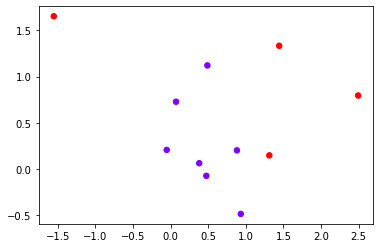

In [9]:
class_1_ = 7 #1类：7个点
class_2_ = 4 #2类：4个点
centers_ = [[0.0, 0.0], [1,1]]
clusters_std = [0.5, 1]
X_, y_ = make_blobs(n_samples=[class_1_, class_2_],
                    centers=centers_,
                    cluster_std=clusters_std,
                    random_state=0,
                    shuffle=False)
plt.scatter(X_[:, 0], X_[:, 1], c=y_, cmap="rainbow",s=30)

### 2.建模，调用概率

In [10]:
from sklearn.linear_model import LogisticRegression as LogiR
clf_lo = LogiR().fit(X_,y_)
prob = clf_lo.predict_proba(X_)

#将样本和概率放到一个DataFrame中
import pandas as pd
prob = pd.DataFrame(prob)
prob.columns = ['0','1']
prob

,0,1
0,0.694619,0.305381
1,0.510931,0.489069
2,0.820038,0.179962
3,0.785647,0.214353
4,0.777387,0.222613
5,0.656634,0.343366
6,0.768586,0.231414
7,0.349171,0.650829
8,0.366184,0.633816
9,0.663272,0.336728


### 3.使用阈值0.5，大于0.5的样本被预测为1，小于0.5的样本被预测为0

In [11]:
#手动调节阈值，来改变我们的模型效果
for i in range(prob.shape[0]):
    if prob.loc[i,'1'] > 0.5:
        prob.loc[i,'pred'] = 1
    else:
        prob.loc[i,'pred'] = 0
prob['y_true'] = y_
prob = prob.sort_values(by='1',ascending=False) #1列的类概率越大越排序靠前
prob

,0,1,pred,y_true
7,0.349171,0.650829,1.0,1
8,0.366184,0.633816,1.0,1
1,0.510931,0.489069,0.0,0
10,0.607529,0.392471,0.0,1
5,0.656634,0.343366,0.0,0
9,0.663272,0.336728,0.0,1
0,0.694619,0.305381,0.0,0
6,0.768586,0.231414,0.0,0
4,0.777387,0.222613,0.0,0
3,0.785647,0.214353,0.0,0


### 4.使用混淆矩阵查看结果

In [12]:
from sklearn.metrics import confusion_matrix as CM, precision_score as P, recall_score as R

In [13]:
CM(prob.loc[:,'y_true'],prob.loc[:,'pred'],labels=[1,0]) #labels：少数类是1，写在前面，多数类是0，写在后面

array([[2, 2],
       [0, 7]], dtype=int64)

In [14]:
P(prob.loc[:,'y_true'],prob.loc[:,'pred'],labels=[1,0])

1.0

In [15]:
R(prob.loc[:,'y_true'],prob.loc[:,'pred'],labels=[1,0])

0.5

### 5.使用0.4作为阈值

In [16]:
for i in range(prob.shape[0]):
    if prob.loc[i,'1'] > 0.4:
        prob.loc[i,'pred'] = 1
    else:
        prob.loc[i,'pred'] = 0
prob

,0,1,pred,y_true
7,0.349171,0.650829,1.0,1
8,0.366184,0.633816,1.0,1
1,0.510931,0.489069,1.0,0
10,0.607529,0.392471,0.0,1
5,0.656634,0.343366,0.0,0
9,0.663272,0.336728,0.0,1
0,0.694619,0.305381,0.0,0
6,0.768586,0.231414,0.0,0
4,0.777387,0.222613,0.0,0
3,0.785647,0.214353,0.0,0


In [17]:
CM(prob.loc[:,"y_true"],prob.loc[:,"pred"],labels=[1,0])

array([[2, 2],
       [1, 6]], dtype=int64)

In [18]:
P(prob.loc[:,"y_true"],prob.loc[:,"pred"],labels=[1,0])

0.6666666666666666

In [19]:
R(prob.loc[:,"y_true"],prob.loc[:,"pred"],labels=[1,0])

0.5

在不同阈值下，模型评估指标会发生变化，我们正利用这一点来观察Recall和FPR之间如何互相影响。

而要体现阈值的影响，首先要得到分类器在少数类下的预测概率。对于逻辑回归这种天生生成似然的算法和朴素贝叶斯这种就是在计算概率的算法，自然非常容易得到概率，但对于一些其他的分类算法，比如决策树、SVM，他们的分类方式和概率并不相关。那在他们身上，我们就无法画ROC曲线了吗？并非如此。

决策树有叶子节点，一个叶子节点上可能包含着不同类的样本。假设一个样本被包含在叶子节点a中，节点a包含10个样本，其中6个为1，4个为0，则1这个正类在这个叶子节点中的出现概率就是60%，类别0在这个叶子节点中的出现概率就是40%。对于所有在这个叶子节点中的样本而言，节点上的1和0出现的概率，就是这个样本对应的取到1和0的概率。但是思考一个问题，由于决策树可以被画得很深，在足够深的情况下，决策树的每个叶子节点上可能都不包含多个类别的标签了，可能一片叶子中只有唯一的一个标签，即叶子节点的不纯度为0，此时此刻，对于每个样本而言，他们所对应的“概率”就是0或者1了。此时就无法调节阈值来调节Recall和FPR了。对于随机森林也是如此。

## （二）SVM实现概率预测

对于SVM，越远离超平面的样本点归属于某个标签类的概率就很大，而接口decision_function返回特征矩阵中每个样本到超平面的距离。所以，到超平面的距离一定程度上反映了样本归属于某个标签类的可能性，接口decision_function的返回值也因此被认为是SVM中的置信度（confidence）。但是置信度不是概率，可以无限大，大部分时候也不是以百分比或者小数的形式呈现，而SVC的判断过程又不像决策树一样可以求解出一个比例。为了解决这个矛盾，SVC有一个重要参数probability。

参数|含义
:-|:-
probability|布尔值，可不填，默认False<br>是否启用概率估计。进行必须在调用fit之前启用它，启用此功能会减慢SVM的运算速度。<br>设置为True则会启动，启用之后，SVC的接口predict_proba和predict_log_proba将生效。<br>在二分类情况下，SVC将使用Platt缩放来生成概率，即在decision_function生成的距离上进行Sigmoid压缩，并附加训练数据的交叉验证拟合，来生成类逻辑回归的SVM分数。<br>

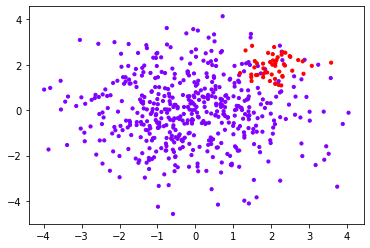

In [20]:
#使用最初的X和y，样本不均衡的这个模型
class_1 = 500 #类别1有500个样本
class_2 = 50 #类别2只有50个
centers = [[0.0, 0.0], [2.0, 2.0]] #设定两个类别的中心
clusters_std = [1.5, 0.5] #设定两个类别的方差，通常来说，样本量比较大的类别会更加松散
X, y = make_blobs(n_samples=[class_1, class_2],
                  centers=centers,
                  cluster_std=clusters_std,
                  random_state=0,
                  shuffle=False)
#看看数据集长什么样
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='rainbow',s=10)
#其中红色点是少数类，紫色点是多数类

In [21]:
clf_proba = svm.SVC(kernel='linear',C=1.0,probability=True).fit(X,y)

In [22]:
clf_proba.predict_proba(X) #生成各类标签下的概率

array([[0.68516091, 0.31483909],
       [0.24211793, 0.75788207],
       [0.96752614, 0.03247386],
       ...,
       [0.13696174, 0.86303826],
       [0.33699551, 0.66300449],
       [0.29535983, 0.70464017]])

In [23]:
clf_proba.predict_proba(X).shape

(550, 2)

In [24]:
clf_proba.decision_function(X)

array([ -0.39182241,   0.95617053,  -2.24996184,  -2.63659269,
        -3.65243197,  -1.67311996,  -2.56396417,  -2.80650393,
        -1.76184723,  -4.7948575 ,  -7.59061196,  -3.66174848,
        -2.2508023 ,  -4.27626526,   0.78571364,  -3.24751892,
        -8.57016271,  -4.45823747,  -0.14034183,  -5.20657114,
        -8.02181046,  -4.18420871,  -5.6222409 ,  -5.12602771,
        -7.22592707,  -5.07749638,  -6.72386021,  -3.4945225 ,
        -3.51475144,  -5.72941551,  -5.79160724,  -8.06232013,
        -4.36303857,  -6.25419679,  -5.59426696,  -2.60919281,
        -3.90887478,  -4.38754704,  -6.46432224,  -4.54279979,
        -4.78961735,  -5.53727469,   1.33920817,  -2.27766451,
        -4.39650854,  -2.97649872,  -2.26771979,  -2.40781748,
        -1.41638181,  -3.26142275,  -2.7712218 ,  -4.87288439,
        -3.2594128 ,  -5.91189118,   1.48676267,   0.5389064 ,
        -2.76188843,  -3.36126945,  -2.64697843,  -1.63635284,
        -5.04695135,  -1.59196902,  -5.5195418 ,  -2.10

In [25]:
clf_proba.decision_function(X).shape

(550,)

在二分类过程中，decision_function只会生成一列距离，样本的类别由距离的符号来判断。此外，由于Platt缩放的理论原因，在二分类过程中，有可能出现predict_proba返回的概率小于0.5，但样本依旧被标记为正类的情况，毕竟支持向量机本身并不依赖于概率来完成自己的分类。如果需要置信度分数，但不一定非要是概率的形式，建议将probability设置为False，使用decision_function这而不是predict_proba。

## （三）绘制SVM的ROC曲线

ROC是一条以不同阈值下的假正率FPR为横坐标，不同阈值下的召回率Recall为纵坐标的曲线。

In [26]:
#首先从混淆矩阵中获取FPR和Recall
cm = CM(prob.loc[:,'y_true'],prob.loc[:,'pred'],labels=[1,0])
cm

array([[2, 2],
       [1, 6]], dtype=int64)

In [27]:
#假正率FPR=预测错误的0/真实的0=1/7
cm[1,0]/cm[1,:].sum()

0.14285714285714285

In [28]:
#召回率Recall=预测正确的1/真实的1=2/4
cm[0,0]/cm[0,:].sum()

0.5

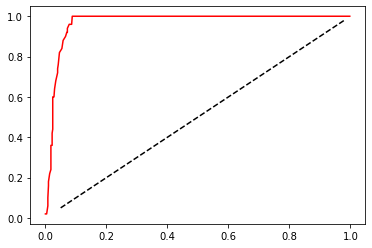

In [29]:
#开始绘图
recall = []
FPR = []
#阈值（endpoint=False不能使用概率最大值作为阈值）
probrange = np.linspace(clf_proba.predict_proba(X)[:,1].min(),clf_proba.predict_proba(X)[:,1].max(),num=50,endpoint=False)

from sklearn.metrics import confusion_matrix as CM, recall_score as R
import matplotlib.pyplot as plot

for i in probrange: #循环50个阈值
    y_predict = []
    for j in range(X.shape[0]):
        if clf_proba.predict_proba(X)[j,1] > i: #大于阈值
            y_predict.append(1) #属于类别1
        else: #小于等于阈值
            y_predict.append(0) #属于类别0
    cm = CM(y,y_predict,labels=[1,0]) #混淆矩阵
    recall.append(cm[0,0]/cm[0,:].sum()) #召回率
    FPR.append(cm[1,0]/cm[1,:].sum()) #假正率
    
recall.sort() #从大到小排序
FPR.sort() #从大到小排序

plt.plot(FPR,recall,c='red')
plt.plot(probrange+0.05,probrange+0.05,c='black',linestyle='--') #y=x
plt.show()

我们希望随着Recall的不断提升，FPR增加得越慢越好，这说明模型可以尽量高效地捕捉出少数类，而不会将很多地多数类判断错误。所以，我们希望纵坐标急速上升，横坐标缓慢增长，也就是在整个图像**左上方**的一条弧线。这代表模型的效果不错，拥有较好的捕获少数类的能力。中间的虚线代表当recall增加1%，我们的FPR也增加1%。

AUC面积代表ROC曲线下方的面积，面积越大，代表ROC曲线越接近左上角，模型就越好。

## （四）sklearn中的ROC曲线和AUC面积

### 1.ROC曲线

`sklearn.metrics.roc_curve`(y_true, y_score, pos_label=None, sample_weight=None, drop_intermediate=True)

**y_true**：数组，形状 = [n_samples]，真实标签。<br>
**y_score**：数组，形状 = [n_samples]，置信度分数，可以是正类样本的概率值，或置信度分数，或者decision_function返回的距离。<br>
**pos_label**：整数或者字符串, 默认None，表示被认为是正类样本的类别。<br>
**sample_weight**：形如 [n_samples]的类数组结构，可不填，表示样本的权重。<br>
**drop_intermediate**：布尔值，默认True，如果设置为True，表示会舍弃一些ROC曲线上不显示的阈值点，这对于计算一个比较轻量的ROC曲线来说非常有用。<br>
这个类依次返回：FPR，Recall以及阈值。

In [30]:
from sklearn.metrics import roc_curve
FPR, recall, thresholds = roc_curve(y,clf_proba.decision_function(X), pos_label=1)

In [31]:
FPR

array([0.   , 0.   , 0.006, 0.006, 0.008, 0.008, 0.01 , 0.01 , 0.014,
       0.014, 0.018, 0.018, 0.022, 0.022, 0.024, 0.024, 0.028, 0.028,
       0.03 , 0.03 , 0.032, 0.032, 0.036, 0.036, 0.04 , 0.04 , 0.042,
       0.042, 0.044, 0.044, 0.05 , 0.05 , 0.054, 0.054, 0.058, 0.058,
       0.066, 0.066, 0.072, 0.072, 0.074, 0.074, 0.086, 0.086, 1.   ])

In [32]:
recall

array([0.  , 0.02, 0.02, 0.06, 0.06, 0.16, 0.16, 0.2 , 0.2 , 0.22, 0.22,
       0.36, 0.36, 0.42, 0.42, 0.6 , 0.6 , 0.62, 0.62, 0.64, 0.64, 0.68,
       0.68, 0.7 , 0.7 , 0.74, 0.74, 0.76, 0.76, 0.82, 0.82, 0.84, 0.84,
       0.86, 0.86, 0.88, 0.88, 0.92, 0.92, 0.94, 0.94, 0.96, 0.96, 1.  ,
       1.  ])

In [33]:
thresholds #此时的threshold就不是概率值，而是距离（decision_function）值中的阈值了，所以它可以大于1，也可以为负

array([  3.18236076,   2.18236076,   1.48676267,   1.35964325,
         1.33920817,   1.14038015,   1.13383091,   1.00003406,
         0.85085628,   0.84476439,   0.78571364,   0.60568093,
         0.5389064 ,   0.46718521,   0.44396046,   0.03907036,
        -0.07011269,  -0.10668727,  -0.1258212 ,  -0.13845693,
        -0.14034183,  -0.16790648,  -0.2040958 ,  -0.22137683,
        -0.24381463,  -0.26762451,  -0.34446784,  -0.3467975 ,
        -0.39182241,  -0.40676459,  -0.4589064 ,  -0.46310299,
        -0.49195707,  -0.5088941 ,  -0.53560561,  -0.55152081,
        -0.62628865,  -0.67580418,  -0.78127198,  -0.79874442,
        -0.88438995,  -0.91257798,  -1.01417607,  -1.08601917,
       -10.31959605])

### 2.AUC面积

`sklearn.metrics.roc_auc_score`(y_true, y_score, average=’macro’, sample_weight=None, max_fpr=None)

In [34]:
from sklearn.metrics import roc_auc_score as AUC
area = AUC(y,clf_proba.decision_function(X))
area #越接近1越好

0.9696400000000001

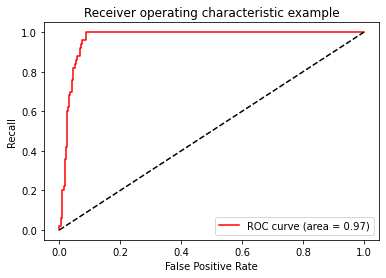

In [35]:
#绘制ROC曲线
plt.figure()
plt.plot(FPR, recall, color='red', label='ROC curve (area = %0.2f)' % area)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('Recall')
plt.title('Receiver operating characteristic example')
plt.legend(loc='lower right') #图例位置右下角
plt.show()

## （五）利用ROC曲线找出最佳阈值

我们希望模型在捕获少数类的能力变强的时候，尽量不误伤多数类，也就是说，随着recall的变大，FPR的大小越小越好。所以我们希望找到的最优点，其实是**Recall和FPR差距最大**的点，这个点，又叫做**约登指数**。

In [36]:
maxindex = (recall - FPR).tolist().index(max(recall - FPR)) #recall-FPR最大值的索引
thresholds[maxindex] #recall-FPR最大时的阈值

-1.0860191749391461

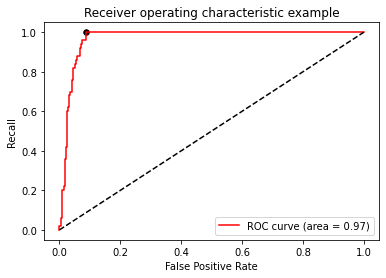

In [37]:
plt.figure()
plt.plot(FPR, recall, color='red',label='ROC curve (area = %0.2f)' % area)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.scatter(FPR[maxindex],recall[maxindex],c='black',s=30) #点
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('Recall')
plt.title('Receiver operating characteristic example')
plt.legend(loc='lower right')
plt.show()

离左上角最近的点，离中间的虚线最远的点，也是ROC曲线的转折点。此外，还可以使用KS曲线或收益曲线(profit chart)来选择阈值。